# Ananta Faadillah Sophan


# Problem Statement
Melakukan segmentasi terhadap negara-negara berdasarkan harapan hidupnya dengan menggunakan KMeans (Unsrupervised Learning)

## Import Libraries

Import Library yang dibutuhkan

In [1]:
!pip install feature_engine

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer
import pylab as pl
# To Evaluate Models
from sklearn.metrics import silhouette_score
from sklearn.metrics import silhouette_samples,davies_bouldin_score, calinski_harabasz_score
from yellowbrick.cluster import KElbowVisualizer
from matplotlib.ticker import FixedLocator, FixedFormatter
warnings.filterwarnings('ignore')

## Data Loading

Import Dataset yang diperlukan dan melakukan sedikit Overview

In [3]:
df = pd.read_csv('/content/life-expectancy.csv')

In [4]:
df.head()

,Rank,Country,Overall Life,Male Life,Female Life,Continent
0,1,Monaco,89.5,85.6,93.5,Europe
1,2,Japan,85.0,81.7,88.5,Asia
2,3,Singapore,85.0,82.3,87.8,Asia
3,4,Macau; China,84.5,81.6,87.6,Asia
4,5,San Marino,83.3,80.7,86.1,Europe


In [5]:
df.tail()

,Rank,Country,Overall Life,Male Life,Female Life,Continent
218,219,Gabon,52.1,51.6,52.5,Africa
219,220,Swaziland,51.6,52.2,51.0,Africa
220,221,Afghanistan,51.3,49.9,52.7,Asia
221,222,Guinea-Bissau,50.6,48.6,52.7,Africa
222,223,Chad,50.2,49.0,51.3,Africa


In [6]:
df.shape

(223, 6)

In [7]:
df.isnull().sum().sum()

0

In [8]:
df[df.duplicated()].shape

(0, 6)

In [9]:
df.isnull().sum()

Rank            0
Country         0
Overall Life    0
Male Life       0
Female Life     0
Continent       0
dtype: int64

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 223 entries, 0 to 222
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Rank          223 non-null    int64  
 1   Country       223 non-null    object 
 2   Overall Life  223 non-null    float64
 3   Male Life     223 non-null    float64
 4   Female Life   223 non-null    float64
 5   Continent     223 non-null    object 
dtypes: float64(3), int64(1), object(2)
memory usage: 10.6+ KB


In [11]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Rank,223.0,112.000000,64.518731,1.0,56.50,112.0,167.50,223.0
Overall Life,223.0,72.487892,8.459335,50.2,67.45,74.9,78.60,89.5
Male Life,223.0,70.041704,8.074942,48.6,64.50,72.2,75.85,85.6
Female Life,223.0,75.019283,8.986633,51.0,69.75,77.9,81.60,93.5


Setelah dilakukan sedikit Overview data, dapat dilihat bahwa tidak ada duplikasi data ataupun Missing Values, Selain itu juga dari statistk deskriptif tidak ditemukan adanya nilai yang aneh. Untuk sementara dapat disimpulkan bahwa data tidak membutuhkan pembersihan, namun untuk Handling outlier akan ditelusuri lebih lanjut di section Handling Outlier



## Exploratory Data Analysis

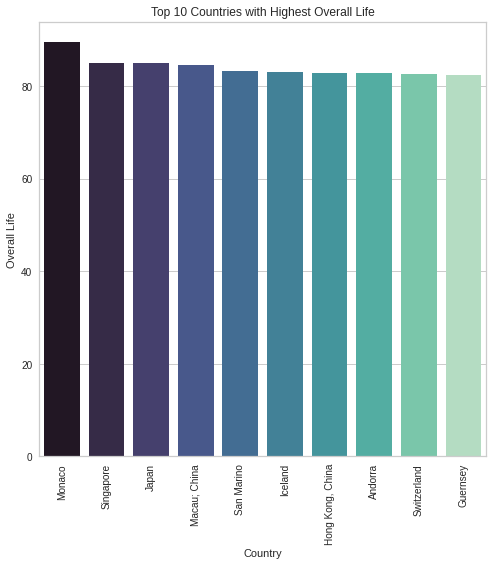

In [12]:
top10_OverallLife = df[['Country','Overall Life']].sort_values('Overall Life', ascending=False).head(10)

plt.figure(figsize=(8,8))
sns.barplot(x='Country', y='Overall Life', data=top10_OverallLife, palette='mako')
plt.title('Top 10 Countries with Highest Overall Life')
plt.xticks(rotation = 90);

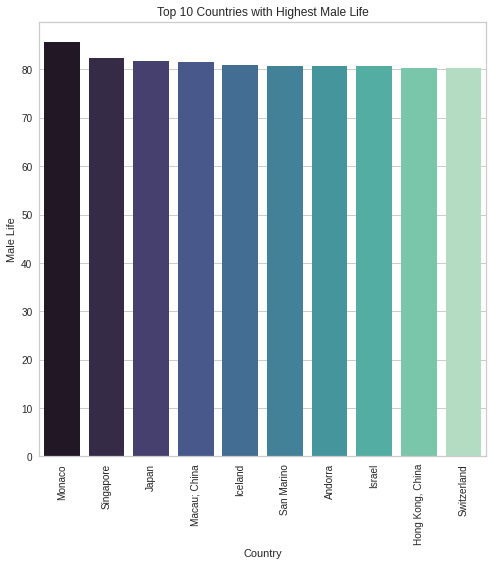

In [13]:
top10_MaleLife = df[['Country','Male Life']].sort_values('Male Life', ascending=False).head(10)

plt.figure(figsize=(8,8))
sns.barplot(x='Country', y='Male Life', data=top10_MaleLife, palette='mako')
plt.title('Top 10 Countries with Highest Male Life')
plt.xticks(rotation = 90);

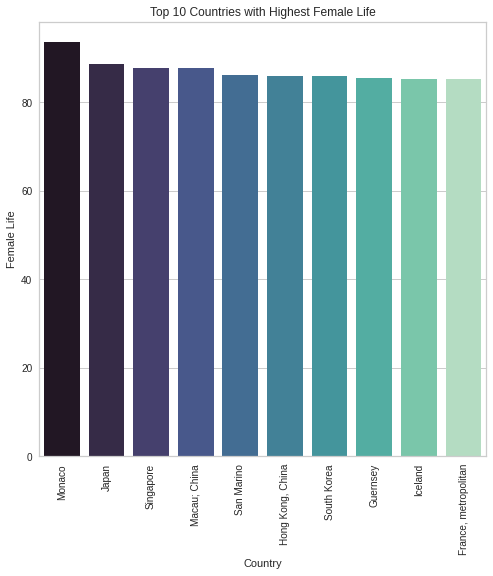

In [14]:
top10_FemaleLife = df[['Country','Female Life']].sort_values('Female Life', ascending=False).head(10)

plt.figure(figsize=(8,8))
sns.barplot(x='Country', y='Female Life', data=top10_FemaleLife, palette='mako')
plt.title('Top 10 Countries with Highest Female Life')
plt.xticks(rotation = 90);

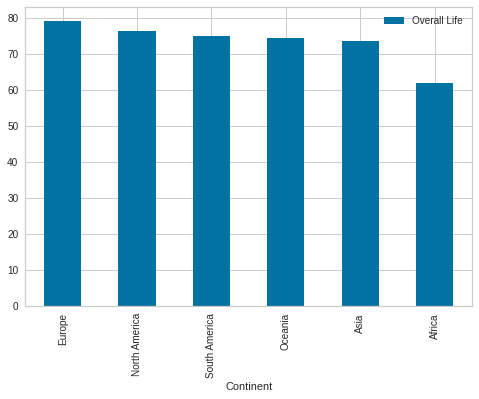

In [15]:
topcontinent = df.groupby('Continent')[['Overall Life']].mean().sort_values('Overall Life', ascending=False).plot(kind='bar')
topcontinent

Berdasarkan Hasil EDA diatas dapat dilihat bahwa:
1. Monaco adalah Negara dengan angka harapan hidup tertingggi. Tidak hanya itu, Monaco juga menduduki posisi tertinggi pada bagian angka harapan hidup pria maupun wanita
2. Dapat dilihat bahwa jika negara memiliki Male Life dan Female Life yang masuk dalam top 10, maka Overall Life negara tersebut juga merupakan top-10 Overall Life
3. Jika dilihat dari penjelasan nomor 2, ada dua kasus pengecualian dimana negara Prancis dan Korea Selatan tidak masuk dalam top 10 negara dengan Overall Life dan Male Life yang terbaik, namun kedua negara tersebut masuk dalam top-10 dalam Female Life tertinggi
4. Overall Life terbaik didominasi oleh benua Eropa, dimana 6 dari 10 negara dengan Overall Life terbaik berasal dari Eropa, diikuti dengan 4 negara dari Asia
5. jika dilihat dari rata-rata Overall Life berdasarkan Benua, Benua Eropa adalah Benua yang memiliki rata-rata Overall Life terbaik.

## Data Preprocessing

### Handling Outlier

In [16]:
df_clean = df.copy()

In [17]:
def plot_dist(df_clean, col):
    fig, axes = plt.subplots(ncols = 2, figsize = (15, 5))

# histogram
    sns.histplot(df_clean[col],ax = axes[0], bins=30)
    axes[0].set_title(f"Histogram '{col}'")
    axes[0].axvline(df_clean[col].mean(), color = 'red', linestyle = 'dashed', label = 'mean')
    axes[0].axvline(df_clean[col].median(), color = 'green', linestyle = 'dashed', label = 'median')
    axes[0].legend()

# boxplot
    if df_clean[col].skew() >= 1 or df_clean[col].skew() <= -1 :
        sns.boxplot(y=df_clean[col], ax =  axes[1], whis=3)
        axes[1].set_title(f"Boxplot '{col}'")
    
        plt.show()
    else:
        sns.boxplot(y=df_clean[col], ax =  axes[1], whis=1.5)
        axes[1].set_title(f"Boxplot '{col}'")
    
        plt.show()
        
# skewness
    print(df_clean[col].name + ' Skewness: ' + str(df_clean[col].skew()))
    if -0.5 <= df_clean[col].skew() <= 0.5:
        print("Columns '{}' normal distribution".format(col))
    elif df_clean[col].skew() > 0.5:
        print("Columns '{}' right skewed".format(col))
    elif df_clean[col].skew() < -0.5:
        print("Columns '{}' left skewed".format(col))

Melihat nilai Skew dan Persebaran datanya

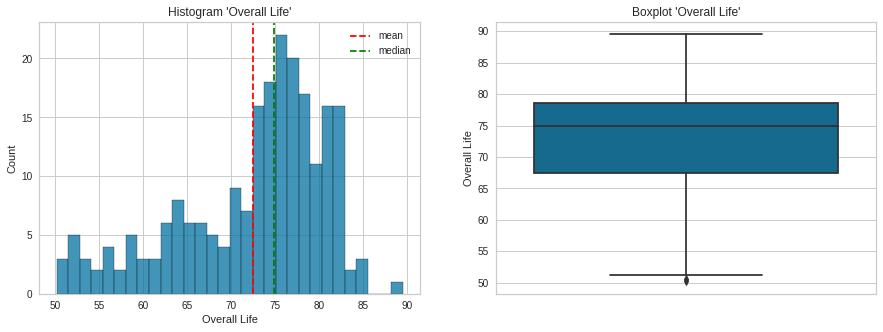

Overall Life Skewness: -0.896327516670228
Columns 'Overall Life' left skewed


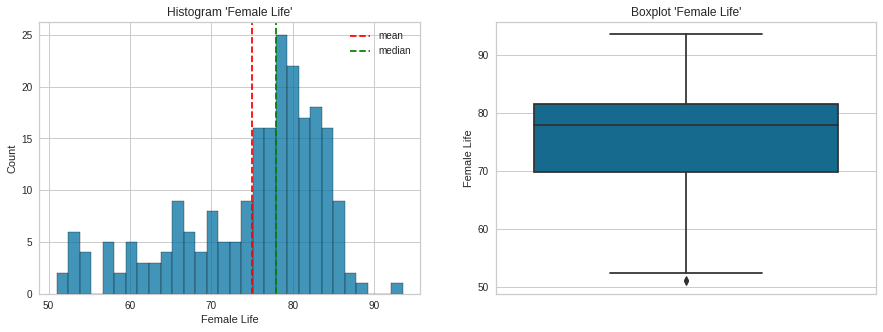

Female Life Skewness: -0.9647680524178575
Columns 'Female Life' left skewed


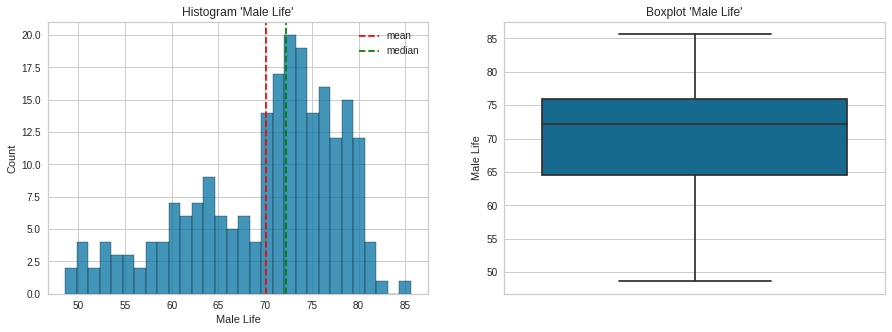

Male Life Skewness: -0.7894352253835046
Columns 'Male Life' left skewed


In [18]:
num = ['Overall Life','Female Life', 'Male Life']
for i in num:
  plot_dist(df_clean,i)

Melihat jumlah Outlier pada setiap kolom dan melihat berapa persentasenya

In [19]:
df_num = df_clean[['Overall Life','Female Life', 'Male Life']]
for k in df_num:
  Q3 = df_num[k].quantile(.75)
  Q1 = df_num[k].quantile(.15)

  IQR = Q3 - Q1

  upper = Q3 + (1.5 * IQR)
  lower = Q1 - (1.5 * IQR)

  outlier = df_num[(df_num[k] > upper) | (df_num[k] < lower)]
  print(k)
  print('count of outlier: ', outlier.shape[0])
  print('percent of outlier: ', outlier.shape[0]/df_num.shape[0] * 100, '%')
  print('='*70)

Overall Life
count of outlier:  0
percent of outlier:  0.0 %
Female Life
count of outlier:  0
percent of outlier:  0.0 %
Male Life
count of outlier:  0
percent of outlier:  0.0 %


Setelah dilihat, Meskipun rata-rata data adalah Left Skew, data tidak memiliki outlier, sehingga dapat disimpulkan bahwa pada kasus kali ini, tidak perlu dilakukan Handling Outlier

### Scaling

Melakukan Scaling dengan StandardScaler

In [20]:
num_col = ['Overall Life','Female Life', 'Male Life']
scaler = StandardScaler()
num_scaled = pd.DataFrame(scaler.fit_transform(df_clean[num_col]))
num_scaled.columns = num_col

df_clean.drop(num_col, axis=1, inplace=True)
df_clean = pd.concat([df_clean.reset_index(drop=True), num_scaled], axis=1)

In [21]:
df_final = df_clean[[
    'Overall Life','Female Life', 'Male Life'
]]

### PCA

In [22]:
pca_scaled=PCA(n_components=3).fit(df_final)
pca_scaled.explained_variance_ratio_

array([9.91968378e-01, 7.76868310e-03, 2.62939033e-04])

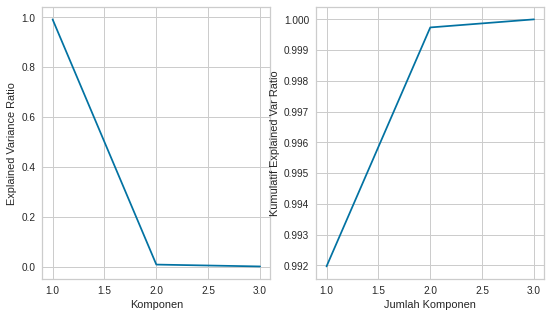

In [23]:
ig,ax=plt.subplots(ncols=2,figsize=(9,5))
ax[0].plot(range(1,4),pca_scaled.explained_variance_ratio_)
ax[0].set_xlabel('Komponen')
ax[0].set_ylabel('Explained Variance Ratio')

ax[1].plot(range(1,4),np.cumsum(pca_scaled.explained_variance_ratio_))
ax[1].set_xlabel('Jumlah Komponen')
ax[1].set_ylabel('Kumulatif Explained Var Ratio')
plt.show()

Berdasarkan grafik EVR diatas, dapat dilihat bahwa patahan ada di nilai 2 dan pada nilai 2 sudah mencakupi informasi data hampir 100%

In [24]:
pca = PCA(n_components=2).fit(df_final)

In [25]:
pca.explained_variance_ratio_

array([0.99196838, 0.00776868])

In [26]:
pca.fit(df_final)

pca_df = pca.transform(df_final)

## Model

### Model Definition

#### K-Means

In [27]:
model1 = KMeans()

##### Elbow Method

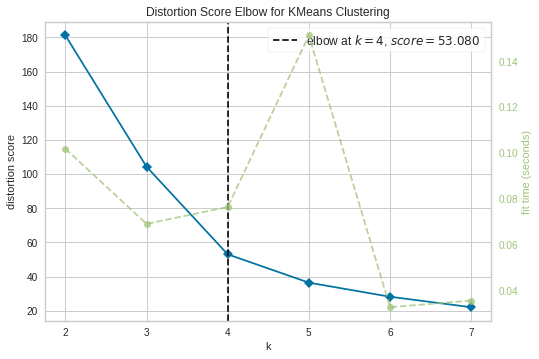

In [28]:
k = [2,3,4,5,6,7,8]
visualizer = KElbowVisualizer(model1, k=(2,8))
visualizer.fit(pca_df)        # Fit the data to the visualizer
visualizer.show()

Dari grafik Elbow Method diatas, dapat dilihat bahwa penurunan yang signifikan berada di nilai 3 dan nilai 4, namun dapat dilihat bahwa score inertia yang terbaik ada di nilai 4, sehingga saya akan mengambil nilai 4

In [29]:
kmeans_per_k = [KMeans(n_clusters=k, random_state=99).fit(pca_df)
                for k in range(1, 10)]
inertias = [model.inertia_ for model in kmeans_per_k]

silhouette_scores = [silhouette_score(pca_df, model.labels_)
                     for model in kmeans_per_k[1:]]

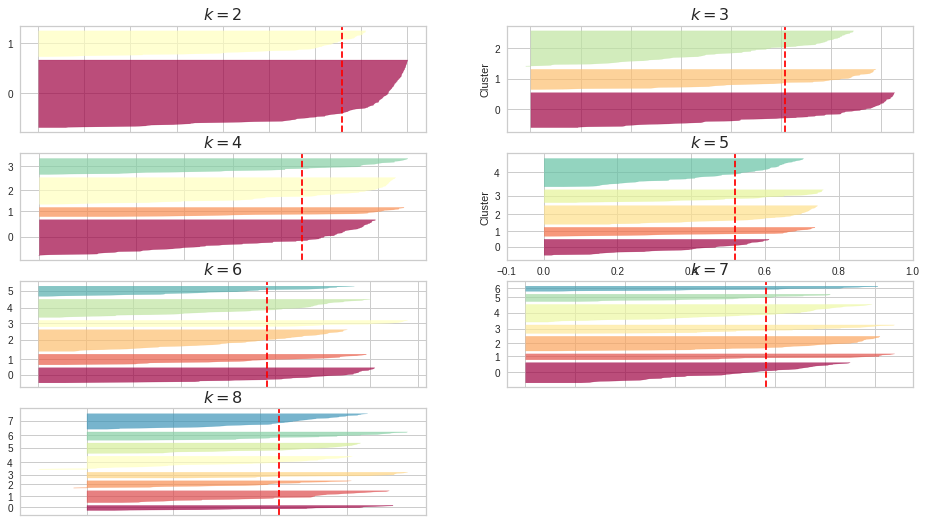

In [30]:
plt.figure(figsize=(16, 9))

for k in (2,3,4,5,6,7,8):
    plt.subplot(4,2,k-1)

    y_pred = kmeans_per_k[k-1].labels_
    silhouette_coefficients = silhouette_samples(pca_df, y_pred)

    padding = len(pca_df) // 30
    pos = padding
    ticks = []
    for i in range(k):
        coeffs = silhouette_coefficients[y_pred == i]
        coeffs.sort()

        color = pl.cm.Spectral(i / k)
        plt.fill_betweenx(np.arange(pos, pos + len(coeffs)), 0, coeffs,
        facecolor=color, edgecolor=color, alpha=0.7)
        ticks.append(pos + len(coeffs) // 2)
        pos += len(coeffs) + padding

    plt.gca().yaxis.set_major_locator(FixedLocator(ticks))
    plt.gca().yaxis.set_major_formatter(FixedFormatter(range(k)))
    if k in (3,5):
        plt.ylabel('Cluster')
    if k in (5,10):
        plt.gca().set_xticks([-0.1,0,0.2,0.4,0.6,0.8,1])
        plt.xlabel('Silhouette Coefficient')
    else:
        plt.tick_params(labelbottom=False)

    plt.axvline(x=silhouette_scores[k-2], color='red', linestyle='--')
    plt.title('$k={}$'.format(k), fontsize=16)

plt.show()

Jika dilihat dari Silhoutte Score, Walaupun semua k tidak memiliki entry data yang tidak diambil (tidak ada tail), dapat dilihat dari plot bahwa pembagian cluster yang paling baik adalah antara k= 3 dan k= 4, namun jika kita juga mengacu pada elbow method, maka tetap k yang diambil adalah k = 4

### Model Training

In [31]:
kmeans = KMeans(n_clusters=4, max_iter=500, random_state=42)
kmeans.fit(pca_df)

KMeans(max_iter=500, n_clusters=4, random_state=42)

In [32]:
kmeans.labels_

array([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1], dtype=int32)

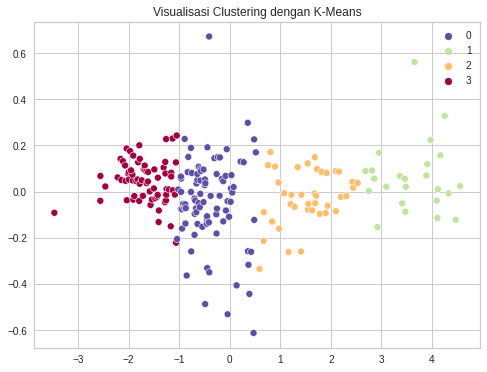

In [33]:
plt.figure(figsize=(8, 6))
ax = sns.scatterplot(x=pca_df[:,0], y=pca_df[:,1], hue=kmeans.labels_, palette='Spectral_r')
ax.set_title('Visualisasi Clustering dengan K-Means');

Jika dilihat berdasarkan visualisasinya, hasil clustering yang didapatkan sudah cukup baik, karena sudah terlihat bisa dipisahkan antara keempat klusternya dan tidak nampak adanya data yang saling overlap.

### Model Evaluation

In [34]:
result = pd.DataFrame({'Method' : ['K-Means'],
                  'Silhouete Score' : [silhouette_score(pca_df, kmeans.labels_)],
                  'Davies Score' : [davies_bouldin_score(pca_df, kmeans.labels_)],
                  'Calinski Score' : [calinski_harabasz_score(pca_df, kmeans.labels_)]})
result

,Method,Silhouete Score,Davies Score,Calinski Score
0,K-Means,0.54201,0.536306,846.827376


In [35]:
df['label'] = kmeans.labels_

In [36]:
df.head()

,Rank,Country,Overall Life,Male Life,Female Life,Continent,label
0,1,Monaco,89.5,85.6,93.5,Europe,3
1,2,Japan,85.0,81.7,88.5,Asia,3
2,3,Singapore,85.0,82.3,87.8,Asia,3
3,4,Macau; China,84.5,81.6,87.6,Asia,3
4,5,San Marino,83.3,80.7,86.1,Europe,3


In [37]:
df['label'].value_counts()

0    90
3    68
2    41
1    24
Name: label, dtype: int64

#### Overall Life

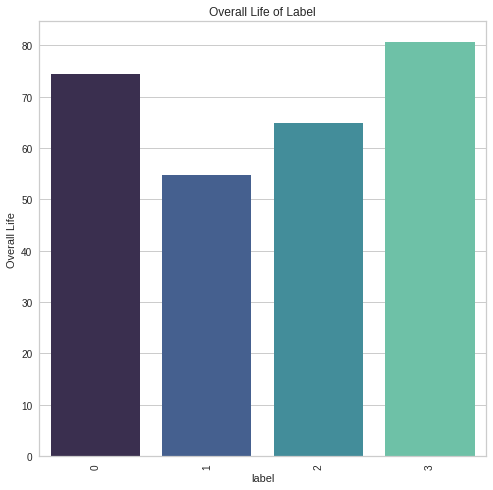

In [67]:
all = df.groupby('label')[['Overall Life']].mean()
all = all.reset_index()

plt.figure(figsize=(8,8))
sns.barplot(x='label', y='Overall Life', data=all, palette='mako')
plt.title('Overall Life of Label')
plt.xticks(rotation = 90);

#### Male Life

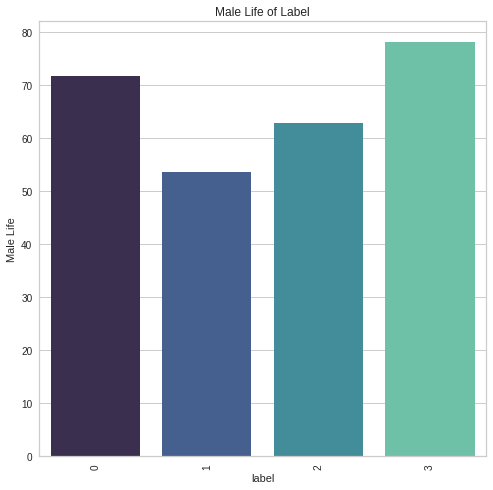

In [66]:
labelm = df.groupby('label')[['Male Life']].mean()
labelm = labelm.reset_index()

plt.figure(figsize=(8,8))
sns.barplot(x='label', y='Male Life', data=labelm, palette='mako')
plt.title('Male Life of Label')
plt.xticks(rotation = 90);

#### Female Life

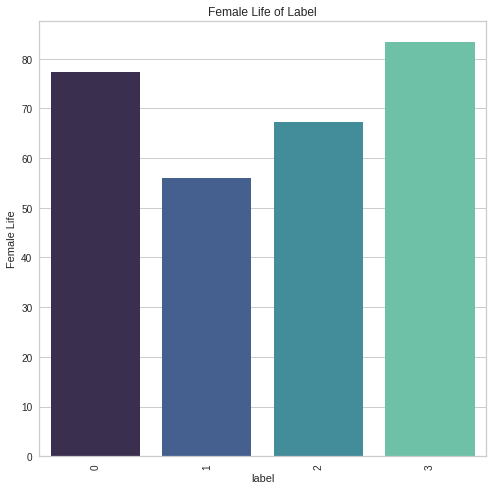

In [63]:
label = df.groupby('label')[['Female Life']].mean()
labelf = label.reset_index()

plt.figure(figsize=(8,8))
sns.barplot(x='label', y='Female Life', data=labelf, palette='mako')
plt.title('Female Life of Label')
plt.xticks(rotation = 90);

#### Continent

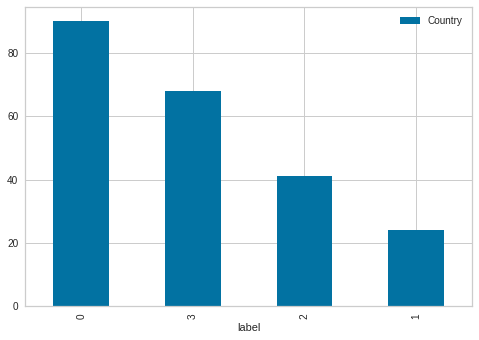

In [41]:
label = df.groupby('label')[['Country']].count().sort_values('Country', ascending=False).plot(kind='bar')
label

In [82]:
labelcount = df.groupby('label')['Country'].count().to_frame()

labelcount

,Country
label,
0,90
1,24
2,41
3,68


## Conclusion

Pada bagian eksplorasi data, apa insight menarik yang bisa kamu ceritakan ?

Berapa cluster yang berhasil kamu peroleh dari dataset tersebut ? Apakah sudah optimal ? Visualisasikan hasil clustering yang kamu peroleh dengan plot 2 dimensi dimana 2 dimensi tersebut merupakan dimensi yang diperoleh dari hasil reduksi dimensi.

Bagaimana karakteristik dari masing-masing cluster ? Bisakah kamu visualisasikan dan ceritakan ?

Apa insight menarik yang kamu peroleh dari jawaban/analisa nomor 3 ?

Dibandingkan dengan EDA, apakah ada kesamaan dari hasil clustering yang kamu peroleh ? Ceritakan analisamu !

--------------------------------------------------------------------------------

Berdasarkan Hasil EDA diatas dapat dilihat bahwa:
1. Monaco adalah Negara dengan angka harapan hidup tertingggi. Tidak hanya itu, Monaco juga menduduki posisi tertinggi pada bagian angka harapan hidup pria maupun wanita
2. Dapat dilihat bahwa jika negara memiliki Male Life dan Female Life yang masuk dalam top 10, maka Overall Life negara tersebut juga merupakan top-10 Overall Life
3. Jika dilihat dari penjelasan nomor 2, ada dua kasus pengecualian dimana negara Prancis dan Korea Selatan tidak masuk dalam top 10 negara dengan Overall Life dan Male Life yang terbaik, namun kedua negara tersebut masuk dalam top-10 dalam Female Life tertinggi
4. Overall Life terbaik didominasi oleh benua Eropa, dimana 6 dari 10 negara dengan Overall Life terbaik berasal dari Eropa, diikuti dengan 4 negara dari Asia
5. jika dilihat dari rata-rata Overall Life berdasarkan Benua, Benua Eropa adalah Benua yang memiliki rata-rata Overall Life terbaik.

jika kita lihat dari clustering yang sudah kita lakukan, maka terdapat 4 cluster yaitu:
- 0: Negara dengan dengan Overall Life cukup tinggi
- 1: Negara dengan dengan Overall Life rendah
- 2: Negara dengan dengan Overall Life cukup rendah 
- 3: Negara dengan dengan Overall Life tinggi




Jika kita lihat pada label 0, Overall Life nya cukup tinggi, begitu pun Female Life dan Male Life nya, hal tersebut juga terjadi pada label lain. Dapat dikatakan bahwa nilai Overall Life berbanding lurus dengan Male Life dan Female Life(semakin naik nilai Female dan Male Life) semakin naik nilai Overall Life.

Sehingga pada kasus kali ini, peringkat Male Life,Female Life, dan Overall Life per label mempunyai kedudukan yang sama



Jika kita lihat dari jumlah negara per benua
- 0: 90 Negara
- 1: 24 negara
- 2: 41 negara
- 3: 68 negara

maka dapat disimpulkan bahwa rata-rata negara di dunia sudah memiliki Overall life yang cukup tinggi, bahkan nilai Overall Life yang dibilang tinggi sudah dimiliki oleh 68 negara. Namun sebanyak 65 negara dari total 223 masih memiliki Overall Life yang dikategorikan rendah

In [85]:
africayn = pd.DataFrame(df['Country'][df['label'] == 1])
africayn

,Country
199,Republic of the Congo
200,Liberia
201,Côte d'Ivoire
202,Cameroon
203,Sierra Leone
204,Zimbabwe
205,Democratic Republic of the Congo
206,Angola
207,Mali
208,Burkina Faso


Jika kita lihat dari EDA awal dan EDA hasil clustering, saat kita melihat bahwa label 1 adalah negara dengan angka harapan hidup rendah, dapat dilihat bahwa negara tersebut didominasi oleh benua afrika. Hal ini memiliki kesamaan pada EDA yang menampilkan bahwa benua afrika adalah benua dengan angka harapan hidup terendah

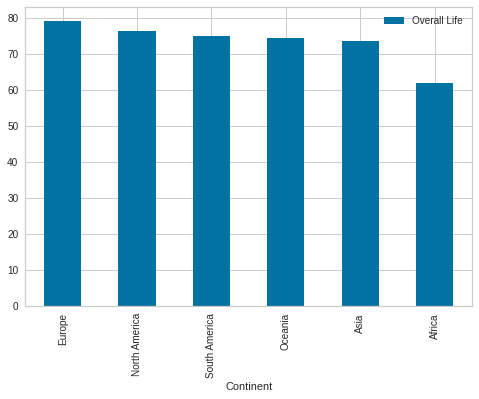

In [86]:
topcontinent2 = df.groupby('Continent')[['Overall Life']].mean().sort_values('Overall Life', ascending=False).plot(kind='bar')
topcontinent2